In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

from models.lstm import LSTMRegressor
from models.kan_encoder import KANEncoder
from utils.stock_data import get_data_loaders, StockIndex
from utils.early_stopping import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
window_size = 7
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 352,
        "num_layers": 1,
        "dropout": 0.28541614143129757,
        "batch_size": 16,
        "lr": 0.00044517259602202056
    },
    StockIndex.AAPL: {
        "hidden_dim": 384,
        "num_layers": 1,
        "dropout": 0.22917171281782978,
        "batch_size": 16,
        "lr": 0.0026358901455780454
    },
    StockIndex.KO: {
        "hidden_dim": 480,
        "num_layers": 1,
        "dropout": 0.19466720673124002,
        "batch_size": 16,
        "lr": 0.0014651429936464527
    }
}

BEST_KAN_PARAMS = {
    StockIndex.NVDA: {
        "kan_hidden_dim": 16,
        "grid": 17,
        "k": 3,
        "lambda_reg": 0.00015850604348303446,
        "lamb_entropy": 1.357774898242835,
        "lamb_l1": 0.7577039060160141,
        "lr": 0.008348045848474997
    },
    StockIndex.AAPL: {
        "kan_hidden_dim": 14,
        "grid": 7,
        "k": 4,
        "lambda_reg": 0.0008473992749287769,
        "lamb_entropy": 1.8281107745369587,
        "lamb_l1": 0.4318753096953138,
        "lr": 0.0005142822936928592
    },
    StockIndex.KO: {
        "kan_hidden_dim": 16,
        "grid": 15,
        "k": 2,
        "lambda_reg": 0.0011561660351474188,
        "lamb_entropy": 0.20492429763030692,
        "lamb_l1": 0.3736639262578805,
        "lr": 0.00479171010072628
    }
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Training KAN-Fixed LSTM for each stock ##

### NVIDIA ###

In [3]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.007060255364782701
Epoch 2: Train=0.00027596053449528745
Epoch 3: Train=0.0003113260339005413
Epoch 4: Train=0.0003995328342804869
Epoch 5: Train=0.0003600899052789736
Epoch 6: Train=0.00032320525934490505
Epoch 7: Train=0.000344895222051583
Epoch 8: Train=0.0002579547987320117
Epoch 9: Train=0.00022637686689826425
Epoch 10: Train=0.000465303397394371
Epoch 11: Train=0.0004244890172625986
Epoch 12: Train=0.0003556856477878296
Epoch 13: Train=0.0002430469494264789
Epoch 14: Train=0.0002504331944627932
Epoch 15: Train=0.0002376170560646734
Epoch 16: Train=0.00017024944610617387
Epoch 17: Train=0.00018508191667456002
Epoch 18: Train=0.00018317565879231258
Epoch 19: Train=0.00018118036222394856
Epoch 20: Train=0.00018304355147149475
Epoch 21: Train=0.00030503407547119866
Epoch 22: Train=0.0002214741987865471
Epoch 23: Train=0.00019818164208007863
Epoch 24: Train=0.00020617953051634797
Epoch 25: Train=0.00019697756713389706
Epoch 26: Train=0.00025634632214805055
Epoch 27: T

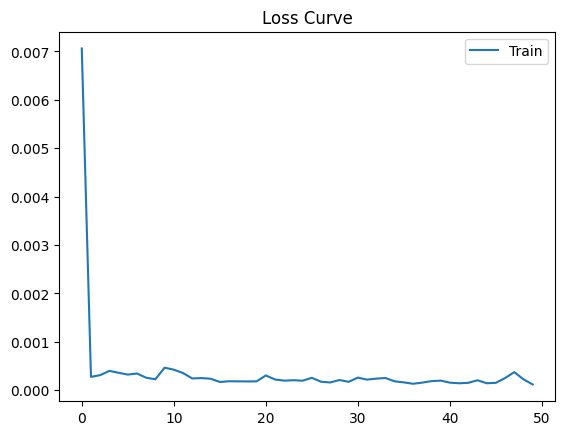

In [4]:
nvda_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

nvda_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    affine_trainable=False,
    symbolic_enabled=False,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': nvda_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': nvda_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    nvda_encoder.train()
    nvda_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = nvda_encoder(xb)
        preds = nvda_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = nvda_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 4.8656
Test MAE : 3.7950


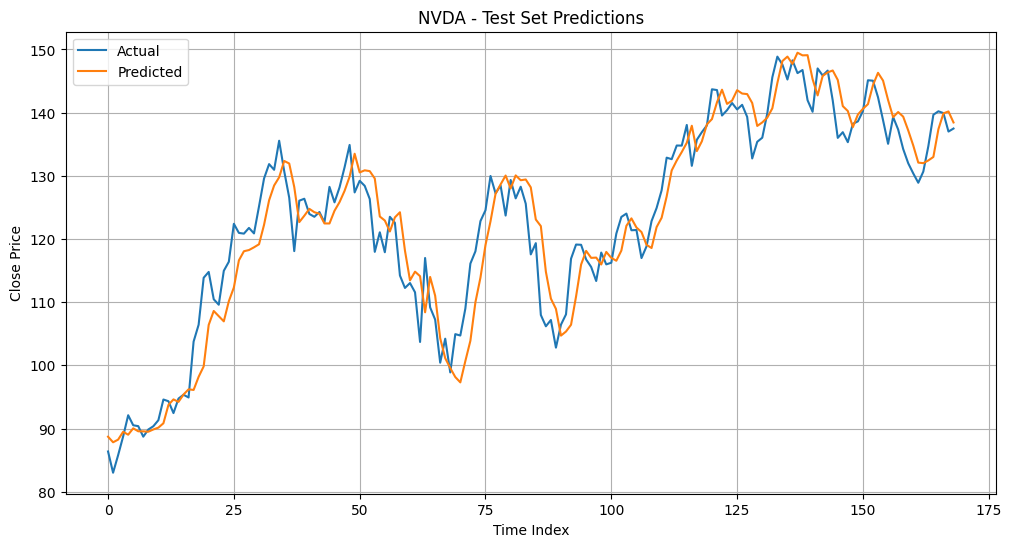

Actual Volatility (std of returns): 0.0328
Predicted Volatility             : 0.0215


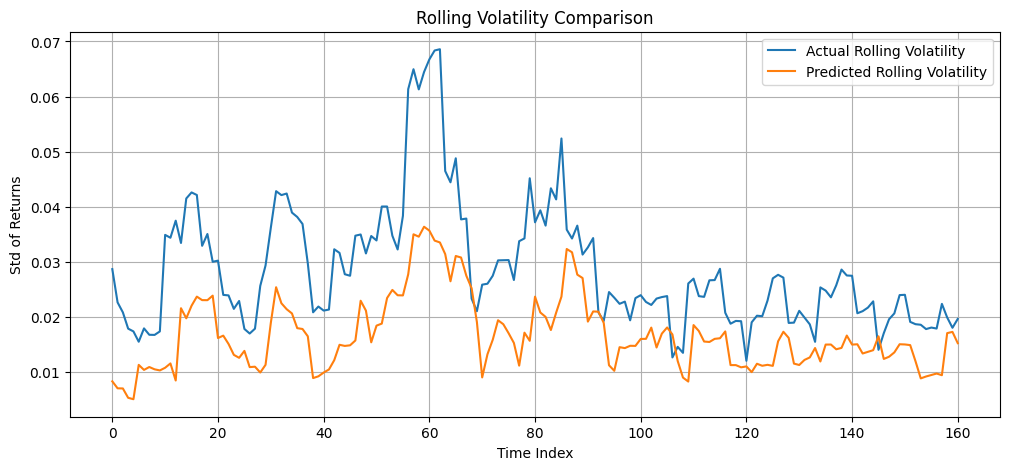

In [5]:
# Ensure both models are in eval mode
nvda_encoder.eval()
nvda_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = nvda_encoder(xb)             # [B, T, D]
        pred = nvda_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
nvda_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
nvda_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(nvda_targets_unscaled, nvda_preds_unscaled))
mae = mean_absolute_error(nvda_targets_unscaled, nvda_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(nvda_targets_unscaled, label="Actual")
plt.plot(nvda_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(nvda_targets_unscaled) / nvda_targets_unscaled[:-1]
pred_returns   = np.diff(nvda_preds_unscaled) / nvda_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Apple ###

In [6]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.030352687097455592
Epoch 2: Train=0.0010705196045543717
Epoch 3: Train=0.0007332656414934782
Epoch 4: Train=0.0006881450688598132
Epoch 5: Train=0.0008584404720823666
Epoch 6: Train=0.0010562539018333108
Epoch 7: Train=0.0011119727713215833
Epoch 8: Train=0.000772358257719786
Epoch 9: Train=0.001044782898253573
Epoch 10: Train=0.0006933339918208676
Epoch 11: Train=0.0008781223312123782
Epoch 12: Train=0.0005185405594106255
Epoch 13: Train=0.0007818227085858734
Epoch 14: Train=0.0006521677375227833
Epoch 15: Train=0.0006741220715062957
Epoch 16: Train=0.0006898853163801679
Epoch 17: Train=0.0007147927554806393
Epoch 18: Train=0.0005057690528573026
Epoch 19: Train=0.0007749691902044832
Epoch 20: Train=0.00048126954355422934
Epoch 21: Train=0.0005197765967382983
Epoch 22: Train=0.0005371427735857045
Epoch 23: Train=0.0004894020830485688
Epoch 24: Train=0.0006475962714334441
Epoch 25: Train=0.0005383994368568176
Epoch 26: Train=0.00044809927931055427
Epoch 27: Train=0.0004

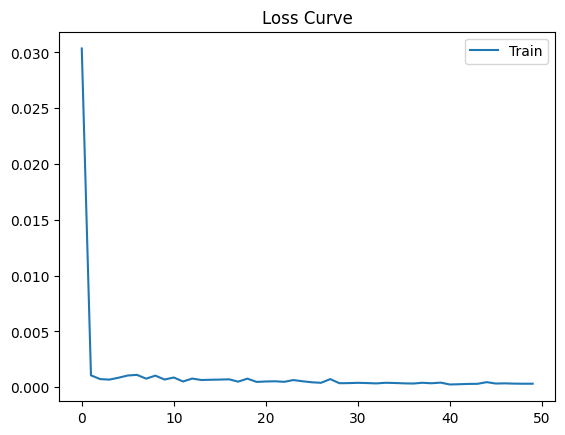

In [7]:
aapl_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

aapl_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=False,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': aapl_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': aapl_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    aapl_encoder.train()
    aapl_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = aapl_encoder(xb)
        preds = aapl_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = aapl_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 7.0045
Test MAE : 5.9075


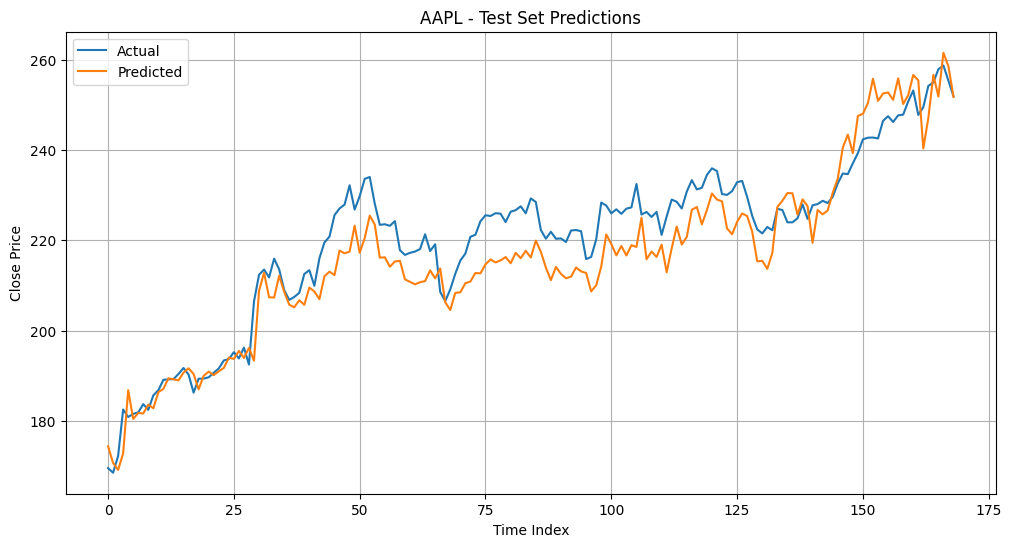

Actual Volatility (std of returns): 0.0145
Predicted Volatility             : 0.0186


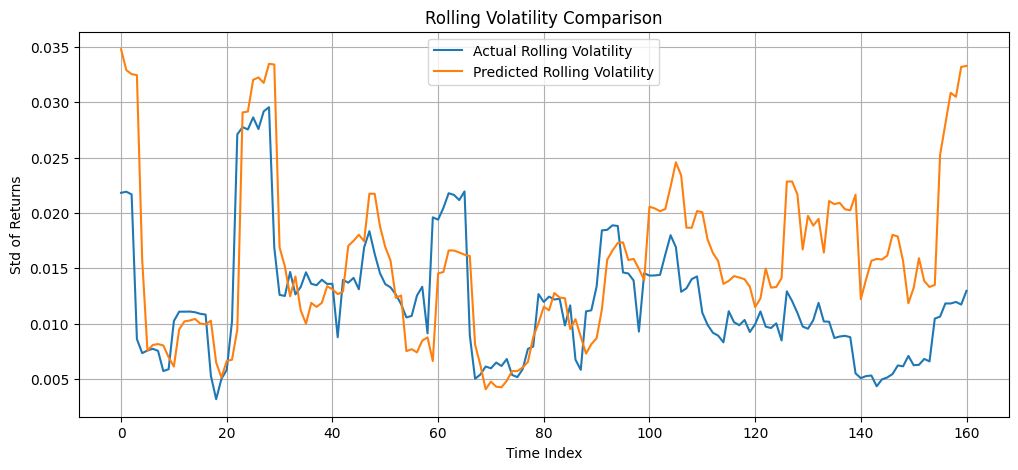

In [8]:
# Ensure both models are in eval mode
aapl_encoder.eval()
aapl_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = aapl_encoder(xb)             # [B, T, D]
        pred = aapl_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
aapl_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
aapl_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(aapl_targets_unscaled, aapl_preds_unscaled))
mae = mean_absolute_error(aapl_targets_unscaled, aapl_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(aapl_targets_unscaled, label="Actual")
plt.plot(aapl_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(aapl_targets_unscaled) / aapl_targets_unscaled[:-1]
pred_returns   = np.diff(aapl_preds_unscaled) / aapl_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Coke ###

In [9]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.01824558139784553
Epoch 2: Train=0.001619749892129083
Epoch 3: Train=0.0015766174021539176
Epoch 4: Train=0.0012090691013115862
Epoch 5: Train=0.0012375605075074492
Epoch 6: Train=0.0010171314766701084
Epoch 7: Train=0.0010216939280684473
Epoch 8: Train=0.0009710732053711333
Epoch 9: Train=0.0008282623082667476
Epoch 10: Train=0.0008990398280068555
Epoch 11: Train=0.0008701280691611553
Epoch 12: Train=0.00076026319981214
Epoch 13: Train=0.0009023323131847487
Epoch 14: Train=0.0008565477854595755
Epoch 15: Train=0.0007534238075922159
Epoch 16: Train=0.0006873480117358879
Epoch 17: Train=0.0005547154803273522
Epoch 18: Train=0.0005980736706546987
Epoch 19: Train=0.0008678371048499501
Epoch 20: Train=0.0005470000065138771
Epoch 21: Train=0.0005643751332301157
Epoch 22: Train=0.0006654579412883543
Epoch 23: Train=0.0005666649176602751
Epoch 24: Train=0.0005288357770592538
Epoch 25: Train=0.000591786049651523
Epoch 26: Train=0.0005903677182034542
Epoch 27: Train=0.000697444

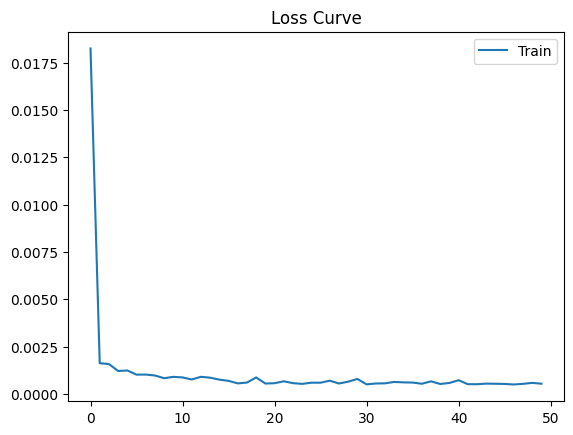

In [10]:
ko_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

ko_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=False,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': ko_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': ko_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []
val_losses = []

best_val_loss = float("inf")
best_model_state = None

for epoch in range(50):
    ko_encoder.train()
    ko_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = ko_encoder(xb)
        preds = ko_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = ko_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 2.0857
Test MAE : 1.9723


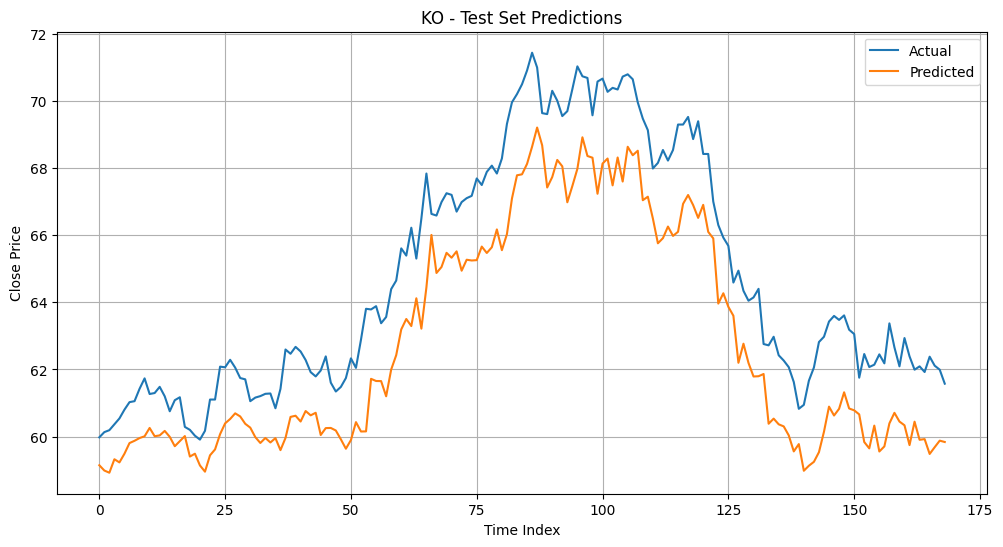

Actual Volatility (std of returns): 0.0083
Predicted Volatility             : 0.0085


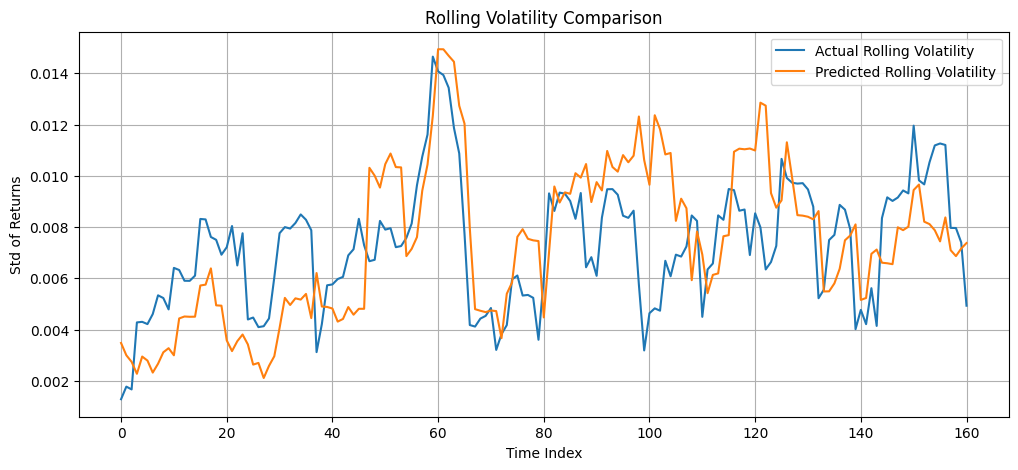

In [11]:
# Ensure both models are in eval mode
ko_encoder.eval()
ko_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = ko_encoder(xb)             # [B, T, D]
        pred = ko_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
ko_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
ko_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(ko_targets_unscaled, ko_preds_unscaled))
mae = mean_absolute_error(ko_targets_unscaled, ko_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(ko_targets_unscaled, label="Actual")
plt.plot(ko_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(ko_targets_unscaled) / ko_targets_unscaled[:-1]
pred_returns   = np.diff(ko_preds_unscaled) / ko_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()